In [6]:
import torch
import torchvision
import numpy as np
import os
from torch.nn import Conv2d, BatchNorm2d, MaxPool2d, ReLU, Sequential, Linear, Embedding, GRU
import cv2
import matplotlib.pyplot as plt
import shutil
from torch.utils.data import Dataset
import glob

In [35]:
BATCH_SIZE = 4
NUM_FEATURE = 256
NUM_HIDDEN = 50
LENGTH = 7
NUM_CHARACTER = 44
NUM_EPOCHS = 500

In [36]:
hangeul_to_idx = {"가":"a", "거":"b", "고":"c", "구":"d", "나":"e", "너":"f", "노":"g", "누":"h", "다":"i", "더":"j", "도":"k", "두":"l", "라":"m", "러":"n", "로":"o", 
                  "루":"p", "마":"q", "머": "r","모":"s", "무":"t", "버":"u", "보":"v", "부":"w", "서":"x", "소":"y", "수":"z", "어":"A", "오":"B", "우":"C", "저":"D", 
                  "조":"E", "주":"F", "하":"G", "호":"H"}
idx_to_char = "0123456789가거고구나너노누다더도두라러로루마머모무버보부서소수어오우저조주하호"

#파일명에 한글이 들어가서 사진을 읽을 때 이 함수로 읽는다 
def my_cv_read_binary(filepath):
    ff = np.fromfile(filepath, dtype = np.uint8)
    gray_img = cv2.imdecode(ff, cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return im_bw

def my_cv_read(filepath):
    ff = np.fromfile(filepath, dtype = np.float)
    img = cv2.imdecode(ff, cv2.IMREAD_COLOR)
    return img

#신식 번호판인지 구식 번호판인지 분류하는 함수
def version_classifier(image):
    if image[10,10] ==0:
        #옛날 번호판
        return 0
    else:
        #신식 번호판
        return 1

#output을 번호판 문자열로
def output_to_plate(output:torch.Tensor):
    output = output.reshape(BATCH_SIZE, LENGTH,-1).cpu().detach().numpy()
    result = []
    for i in range(BATCH_SIZE):
        temp = []
        for j in range(LENGTH):
            temp.append(idx_to_char[output[i][j].argmax()])
        result.append(temp)
    return result

In [37]:
class conv_block(torch.nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size = 3, stride = 1, padding = 1, pool_width = 2):
        super(conv_block, self).__init__()
        model = []
        model.append(Conv2d(in_channel, out_channel, kernel_size = kernel_size, stride = stride, padding = padding))
        model.append(BatchNorm2d(out_channel))
        model.append(ReLU())
        model.append(MaxPool2d((pool_width, pool_width)))
        self.model = Sequential(*model)
        
    def forward(self, input_):
        return self.model(input_)
    
class CNN_RNN(torch.nn.Module):
    def __init__(self, input_size,  hidden_size,output_size, batch_size, num_layers = 2):
        super(CNN_RNN, self).__init__()
        self.cnn_block1 = conv_block(3, 16)
        self.cnn_block2 = conv_block(16,32)
        self.cnn_block3 = conv_block(32,64)
        self.cnn_block4 = conv_block(64,128)
        self.cnn_block5 = conv_block(128,256)
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        #self.encoder = Embedding(input_size, embedding_size)
        self.rnn = GRU(input_size, hidden_size, num_layers=2,bias=True, batch_first=True)
        self.decoder = Linear(hidden_size, output_size)
        
    def cnn_features(self, input_):
        x = self.cnn_block1(input_)
        x = self.cnn_block2(x)
        x = self.cnn_block3(x)
        x = self.cnn_block4(x)
        return self.cnn_block5(x)


    def init_hidden(self):
        hidden = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
        return hidden
                             
    def forward(self, input_, hidden):
        x = self.cnn_features(input_)
        x = x.reshape(self.batch_size, 7, 256)
        #이 때 x의 shape는 (batch_size, 7,256)
        
        
        # RNN 시작
        #x = x.reshape(self.batch_size, -1)
        #x = self.encoder(x)
        x,hidden = self.rnn(x, hidden)
        return self.decoder(x), hidden
        

In [38]:
class Custom_Dataset(Dataset):
    def __init__(self, root_dir, batch_size = BATCH_SIZE, n_character = NUM_CHARACTER, train = True, transform = None):
        super(Custom_Dataset, self).__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.batch_size = batch_size
        self.n_character = n_character
        self.map = {"0" : 0, "1": 1, "2":2, "3":3, "4":4, "5":5, "6":6,"7":7,"8":8,"9":9,"가":10, "거":11, "고":12, "구":13, 
                    "나":14, "너":15, "노":16, "누":17, "다":18, "더":19, "도":20, "두":21, "라":22, "러":23, "로":24, 
                  "루":25, "마":26, "머": 27,"모":28, "무":29, "버":30, "보":31, "부":32, "서":33, "소":34, "수":35,
                    "어":36, "오":37, "우":38, "저":39, "조":40, "주":41, "하":42, "호":43}

        if train:
            self.image_paths = glob.glob("./new_data" + "/train/" + "*")
        else:
            self.image_paths = glob.glob("./new_data" + "/test/"  +  "*")
            
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        file_path = self.image_paths[idx]
        image = my_cv_read(file_path)
        image = transform(image)
        label = self.make_label(file_path[-11:-4])
        return (image, label)
    
    def make_label(self, label):
        tensor_label = torch.zeros(len(label), dtype = torch.long)
        for i in range(len(label)):
            tensor_label[i] = self.map[label[i]]
        return tensor_label

In [39]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((32,228)), torchvision.transforms.ToTensor()])
train_dataset = Custom_Dataset("./new_data", train = True, transform = transform)
test_dataset = Custom_Dataset("./new_data", train = False, transform = transform)

In [40]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, drop_last =True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, drop_last = True)

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_RNN(NUM_FEATURE, NUM_HIDDEN, NUM_CHARACTER ,BATCH_SIZE).to(device)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [48]:
model.train()
for epoch in range(NUM_EPOCHS):
    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.reshape(-1).to(device)
        hidden = model.init_hidden().to(device)

        optimizer.zero_grad()
        output,hidden = model(image,hidden)
        output = output.reshape(-1, NUM_CHARACTER)
        loss = loss_func(output, label)
        loss.backward()
        optimizer.step()

    if epoch % 10==0:
        print("epoch : {}, loss : {}".format(epoch, loss))


epoch : 0, loss : 7.62939453125e-05
epoch : 10, loss : 1.4850071238470264e-05
epoch : 20, loss : 7.901872777438257e-06
epoch : 30, loss : 3.9509363887191284e-06
epoch : 40, loss : 1.8392290712654358e-06
epoch : 50, loss : 8.174351364687027e-07
epoch : 60, loss : 2.0435878411717567e-07
epoch : 70, loss : 2.384185791015625e-07
epoch : 80, loss : 0.13341949880123138
epoch : 90, loss : 0.00021311214368324727
epoch : 100, loss : 7.234300574054942e-05
epoch : 110, loss : 2.3944037820911035e-05
epoch : 120, loss : 7.595334864163306e-06
epoch : 130, loss : 3.4740992305160034e-06
epoch : 140, loss : 2.009528088819934e-06
epoch : 150, loss : 1.1920928955078125e-06
epoch : 160, loss : 6.130763381406723e-07


KeyboardInterrupt: 

In [50]:
torch.save(model.state_dict(), "./model/RNN+CNN.pth")

# 테스트

[['0', '1', '오', '2', '0', '2', '6'], ['0', '3', '모', '2', '9', '4', '5'], ['0', '5', '로', '6', '0', '3', '3'], ['1', '0', '주', '0', '6', '8', '5']]


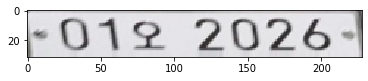

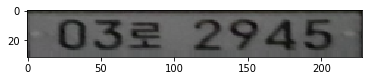

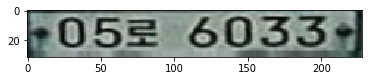

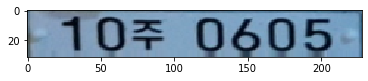

[['1', '3', '도', '8', '4', '1', '9'], ['1', '8', '버', '1', '2', '2', '0'], ['2', '1', '로', '8', '2', '4', '2'], ['2', '3', '하', '5', '8', '2', '6']]


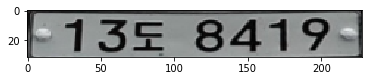

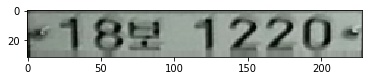

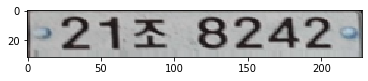

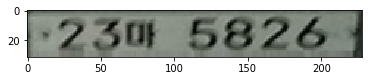

[['2', '4', '고', '8', '3', '5', '3'], ['2', '4', '저', '8', '8', '2', '9'], ['2', '7', '부', '7', '5', '3', '9'], ['3', '2', '보', '6', '1', '9', '1']]


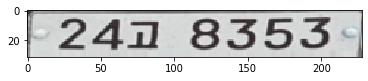

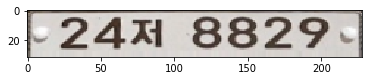

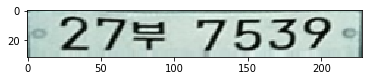

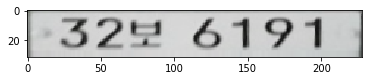

[['3', '3', '보', '8', '5', '9', '4'], ['3', '6', '로', '5', '3', '4', '0'], ['3', '8', '러', '0', '8', '1', '7'], ['4', '2', '구', '8', '1', '4', '6']]


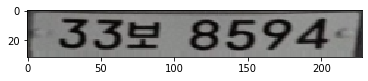

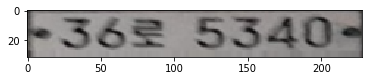

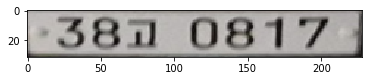

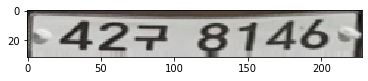

[['4', '3', '무', '7', '7', '0', '7'], ['4', '8', '구', '0', '7', '9', '9'], ['4', '8', '오', '8', '9', '6', '0'], ['4', '9', '고', '3', '5', '2', '3']]


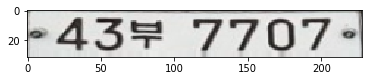

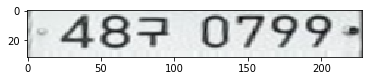

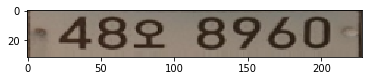

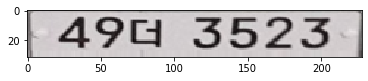

[['5', '0', '무', '5', '8', '1', '0'], ['5', '1', '소', '5', '1', '0', '0'], ['5', '3', '구', '6', '1', '2', '8'], ['5', '4', '머', '1', '1', '0', '6']]


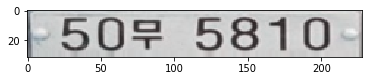

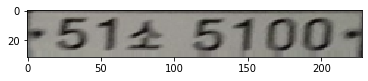

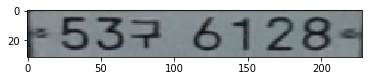

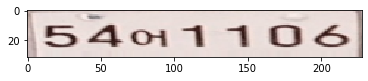

[['5', '5', '더', '3', '8', '9', '7'], ['5', '6', '저', '1', '0', '6', '3'], ['5', '7', '고', '4', '7', '9', '0'], ['5', '8', '마', '3', '5', '1', '5']]


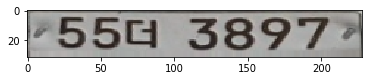

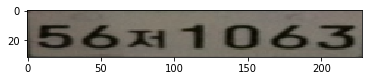

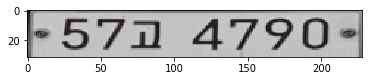

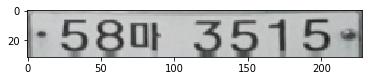

[['6', '0', '머', '9', '2', '9', '4'], ['6', '1', '누', '9', '4', '2', '7'], ['6', '2', '버', '4', '0', '9', '6'], ['6', '4', '저', '6', '0', '0', '4']]


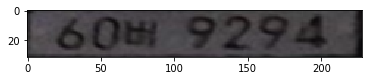

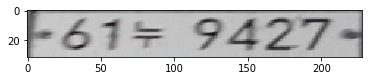

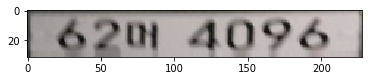

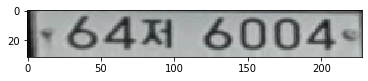

[['6', '7', '루', '4', '8', '3', '5'], ['6', '9', '더', '9', '0', '0', '7'], ['1', '1', '머', '5', '7', '3', '6'], ['1', '3', '조', '0', '8', '3', '3']]


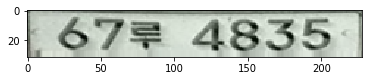

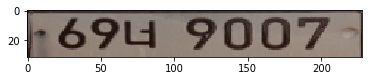

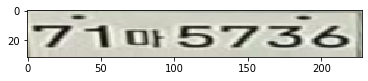

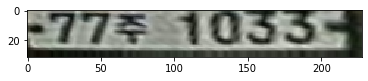

[['8', '1', '수', '8', '8', '0', '3'], ['8', '6', '마', '0', '7', '2', '4'], ['2', '0', '누', '8', '8', '6', '1'], ['0', '4', '로', '2', '4', '7', '8']]


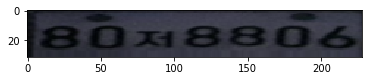

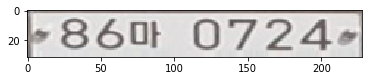

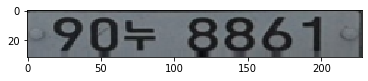

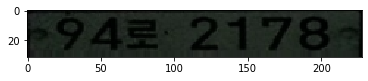

In [54]:
model.eval()
with torch.no_grad():
    for image, label in test_loader:
        image = image.to(device)
        hidden = model.init_hidden().to(device)
        output2,_ = model(image,hidden)
        print(output_to_plate(output2))
        np_image = image.cpu().detach().numpy().transpose(0,2,3,1)
        for image in np_image:
            plt.imshow(image)
            plt.show()

In [55]:
correct = 0
total = 280
model.eval()
with torch.no_grad():
    for image, label in test_loader:
        image = image.to(device)
        hidden = model.init_hidden().to(device)
        output2,_ = model(image,hidden)
        np_image = image.cpu().detach().numpy().transpose(0,2,3,1)
        predict = output_to_plate(output2)
        for i in range(4):
            for j in range(7):
                if predict[i][j] == idx_to_char[label[i][j]]:
                    correct +=1
        
    print("accuracy : {}%".format(100*correct/total))

accuracy : 91.07142857142857%
